# Examine ALOS2 Archive for Grand Mesa SnowEX 2019 AOI

### full catalog search (*no ability to download as of 10/2018)
https://satpf.jp/spf/?sb=search&sensor=ALOS-2_PALSAR-2&item=sb1_sar_palser2

### JAXA search requires old version of firefox that can use Microsoft silverlight (can download csv, kmz, shp)
https://auig2.jaxa.jp/ips/home?language=en_US


In [1]:
import pandas as pd
from pandas.plotting import table
import geopandas as gpd
import shapely
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
%matplotlib inline
#%qtconsole
plt.rcParams['font.size'] = 12

In [3]:
# Read everything 
# !! WARNING !! need to add comma at end of first row of heading labels
path = '/Users/scott/Documents/GitHub/snowex/snowex2019/co-nm/GM2ER1_092aa_ALOS2/alos2-grandmesa-2019.csv'
df = pd.read_csv(path)
#print(df.keys().tolist())
#df.head()
df.tail()

Sensor Name Operation Mode               Scene ID  OBS Path Number  \
69    PALSAR-2            SM3  ALOS2224842840-180722              160   
70    PALSAR-2            SM3  ALOS2228760770-180818               59   
71    PALSAR-2            SM3  ALOS2228760780-180818               59   
72    PALSAR-2            SM3  ALOS2230830770-180901               59   
73    PALSAR-2            SM3  ALOS2237262840-181014              160   

    Centre Frame Number Orbit Data Type Observation Start Date  \
69                 2840     Fixed orbit    2018/07/22 12:09:51   
70                  770     Fixed orbit    2018/08/17 23:57:33   
71                  780     Fixed orbit    2018/08/17 23:57:33   
72                  770     Fixed orbit    2018/08/31 23:57:33   
73                 2840     Fixed orbit    2018/10/14 12:09:51   

   Observation End Date Satellite Name Orbit Direction     ...       \
69  2018/07/22 12:10:34         ALOS-2      Descending     ...        
70  2018/08/18 00:00:26         ALOS-2       Ascending     ...        
71  2018/08/18 00:00:26         ALOS-2       Ascending     ...        
72  2018/09/01 00:05:25         ALOS-2       Ascending     ...        
73  2018/10/14 12:10:35         ALOS-2      Descending     ...        

   Processing Level 0         Scene Identification ID  Disaster Area  \
69                Yes  SARD000000214018-00053-001-001            NaN   
70                Yes  SARD000000217895-00015-001-014            NaN   
71                Yes  SARD000000217895-00015-001-015            NaN   
72                Yes  SARD000000220112-00020-001-014            NaN   
73                Yes  SARD000000226890-00051-001-001            NaN   

    Disaster Country  Disaster Region  Disaster Type  Disaster Accrual Date  \
69               NaN              NaN            NaN                    NaN   
70               NaN              NaN            NaN                    NaN   
71               NaN              NaN            NaN                    NaN   
72               NaN              NaN            NaN                    NaN   
73               NaN              NaN            NaN                    NaN   

    Disaster Name Disaster Memo Unnamed: 109  
69            NaN           NaN          NaN  
70            NaN           NaN          NaN  
71            NaN           NaN          NaN  
72            NaN           NaN          NaN  
73            NaN           NaN          NaN  

[5 rows x 110 columns]

In [4]:
# Make sure it is just PALSAR-2
df["Satellite Name"].unique()

array(['ALOS-2'], dtype=object)

In [5]:
# How many observation modes:
df["Operation Mode"].unique()

array(['SM1', 'SM3', 'SM2'], dtype=object)

In [6]:
# How many observation modes:
df["Beam No"].unique()

array(['U2-6', 'F2-7', 'F2-5', 'F2-6', 'U2-9', 'U2-7', 'U2-8', 'FP6-6',
       'FP6-5', 'FP6-4', 'FP6-3', 'FP6-7'], dtype=object)

In [7]:
# How many observation modes:
df["OBS Path Number"].unique()

array([161,  60,  59, 160, 162])

In [8]:
print('Total acquisitions:', len(df))
print(df["Observation Start Date"].min(), df["Observation Start Date"].max())

Total acquisitions: 74
2014/08/29 12:15:12 2018/10/14 12:09:51


In [9]:
# Simple groupby beam mode counts
df.groupby(["Operation Mode", "Beam No"])["Scene ID"].count()

Operation Mode  Beam No
SM1             U2-6        4
                U2-7        1
                U2-8        2
                U2-9        4
SM2             FP6-3       2
                FP6-4       2
                FP6-5       1
                FP6-6       2
                FP6-7       1
SM3             F2-5       22
                F2-6       14
                F2-7       19
Name: Scene ID, dtype: int64

In [10]:
df.groupby(["Operation Mode", "OBS Path Number"])["Scene ID"].count()

Operation Mode  OBS Path Number
SM1             160                 5
                161                 6
SM2             59                  6
                60                  2
SM3             59                 26
                60                 17
                160                 6
                161                 4
                162                 2
Name: Scene ID, dtype: int64

In [11]:
# Simple groupby beam mode counts
df.groupby(["Orbit Direction", "OBS Path Number"])["Scene ID"].count()

Orbit Direction  OBS Path Number
Ascending        59                 32
                 60                 19
Descending       160                11
                 161                10
                 162                 2
Name: Scene ID, dtype: int64

In [12]:
# Convenient Summary!
df.groupby(["Orbit Direction", "Operation Mode", "OBS Path Number", "Centre Frame Number", "Beam No"])["Scene ID"].count()

Orbit Direction  Operation Mode  OBS Path Number  Centre Frame Number  Beam No
Ascending        SM2             59               770                  FP6-3      1
                                                                       FP6-4      1
                                                                       FP6-5      1
                                                                       FP6-6      1
                                                  780                  FP6-3      1
                                                                       FP6-4      1
                                 60               770                  FP6-6      1
                                                                       FP6-7      1
                 SM3             59               770                  F2-5       9
                                                                       F2-6       8
                                                  780                  F2-5      

In [13]:
# # NOTE that only same Operation Mode, OBS Path, Frame, Beam No, can be used for interferometry
# Select count > 2 from this groupby
order = ["Orbit Direction", "Operation Mode", "OBS Path Number", "Centre Frame Number", "Beam No"]
DF = df.groupby(order).filter(lambda x: len(x["Scene ID"]) > 2)
# Reprint summary as groupby object
DF.groupby(order)["Scene ID"].count()

Orbit Direction  Operation Mode  OBS Path Number  Centre Frame Number  Beam No
Ascending        SM3             59               770                  F2-5       9
                                                                       F2-6       8
                                                  780                  F2-5       9
                                 60               760                  F2-7       6
                                                  770                  F2-6       5
                                                                       F2-7       6
Descending       SM3             160              2840                 F2-7       5
Name: Scene ID, dtype: int64

In [14]:
# NOTE: an alternative to the above!

# Select only paths with more than 10 coincidident acquisitions
#idx = df.groupby(["Operation Mode", "OBS Path Number"])["Scene ID"].count().gt(10) #RETURNS GROUP-BY
#idx = df.groupby(["Operation Mode", "OBS Path Number"])["Scene ID"].transform("count").gt(10) # RETURNS dataframe index
#DF = df[idx]

In [15]:
DF.groupby(["Orbit Direction", "Operation Mode", "OBS Path Number", "Centre Frame Number"])["Scene ID"].count()

Orbit Direction  Operation Mode  OBS Path Number  Centre Frame Number
Ascending        SM3             59               770                    17
                                                  780                     9
                                 60               760                     6
                                                  770                    11
Descending       SM3             160              2840                    5
Name: Scene ID, dtype: int64

In [16]:
def make_footprints(df):
    """ extract shapely polygon footprint"""
    polys = []
    for i,row in df.iterrows():
        uly = row["Scene Upper Left Latitude"]
        ulx = row["Scene Upper Left Longitude"]
        ury = row["Scene Upper Right Latitude"] 
        urx = row["Scene Upper Right Longitude"]
        lly = row["Scene Lower Left Latitude"] 
        llx = row["Scene Lower Left Longitude"] 
        lry = row["Scene Lower Right Latitude"]
        lrx = row["Scene Lower Right Longitude"]
        coords = [ (ulx, uly), (urx, ury), (lrx, lry), (llx, lly), (ulx, uly)]
        polys.append(shapely.geometry.Polygon(np.array(coords).astype('f4')))

    return polys

In [17]:
# Add Polygon footprints
polys = make_footprints(DF)
gf = gpd.GeoDataFrame(DF, geometry=polys, crs={'init': 'epsg:4326'})

# Keep most relevant columns
cols = ["Scene ID", 
        "Operation Mode", 
        "Beam No",
        "OBS Path Number", 
        "Centre Frame Number", 
        "Observation Start Date", 
        "Orbit Direction",
        "Off Nadir Angle",
        "Polarization", 
        "geometry"] 
gf = gf.loc[:, cols]
gf.head()

Scene ID Operation Mode Beam No  OBS Path Number  \
2  ALOS2016290760-140911            SM3    F2-7               60   
3  ALOS2016290770-140911            SM3    F2-7               60   
4  ALOS2017620770-140920            SM3    F2-5               59   
5  ALOS2017620780-140920            SM3    F2-5               59   
6  ALOS2019690770-141004            SM3    F2-6               59   

   Centre Frame Number Observation Start Date Orbit Direction  \
2                  760    2014/09/11 00:00:37       Ascending   
3                  770    2014/09/11 00:00:37       Ascending   
4                  770    2014/09/19 23:53:39       Ascending   
5                  780    2014/09/19 23:53:39       Ascending   
6                  770    2014/10/03 23:53:31       Ascending   

   Off Nadir Angle Polarization  \
2             36.2        HH+HV   
3             36.2        HH+HV   
4             28.2        HH+HV   
5             28.2        HH+HV   
6             32.5        HH+HV   

                                            geometry  
2  POLYGON ((-107.9029998779297 38.86600112915039...  
3  POLYGON ((-108.0139999389648 39.36000061035156...  
4  POLYGON ((-107.8170013427734 39.13999938964844...  
5  POLYGON ((-107.9390029907227 39.63399887084961...  
6  POLYGON ((-107.0479965209961 39.25299835205078...

In [18]:
# Rename to dinosar conventions
gf.rename(columns={"Observation Start Date" : 'sceneDate', 
                "OBS Path Number" : 'relativeOrbit', 
                "Orbit Direction" : 'flightDirection',
                "Scene ID" : 'sceneId',
                "Operation Mode" : 'opMode',
                "Beam No" : 'beamNo',
                "Centre Frame Number" : 'frame',
                "Off Nadir Angle" : 'incidence',
                "Polarization" : 'polarization'}, 
         inplace=True)
#gf.to_file('query-alos2-dinosar.geojson', driver='GeoJSON')

In [19]:
# Plot these frames on a map
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.io.img_tiles import GoogleTiles

In [20]:
def plot_map(gf, snwe, vectorFile=None, zoom=8, title='Orbital Footprints', tableFrame=None):
    pad = 1
    S, N, W, E = snwe
    plot_CRS = ccrs.PlateCarree()
    geodetic_CRS = ccrs.Geodetic()
    x0, y0 = plot_CRS.transform_point(W-pad, S-pad, geodetic_CRS)
    x1, y1 = plot_CRS.transform_point(E+pad, N+pad, geodetic_CRS)

    fig, ax = plt.subplots(figsize=(5, 5), dpi=150,
                           subplot_kw=dict(projection=plot_CRS))

    ax.set_xlim((x0, x1))
    ax.set_ylim((y0, y1))
    url = 'http://tile.stamen.com/terrain/{z}/{x}/{y}.png'
    tiler = GoogleTiles(url=url)
    # NOTE: going higher than zoom=8 is slow...
    ax.add_image(tiler, zoom)

    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='110m',
        facecolor='none')
    ax.add_feature(states_provinces, edgecolor='k', linestyle=':')
    ax.coastlines(resolution='10m', color='black', linewidth=2)
    ax.add_feature(cfeature.BORDERS)
    
    if type(tableFrame) == gpd.geodataframe.GeoDataFrame:
        table(ax, tableFrame, loc='top', zorder=10, fontsize=10,
          cellLoc='center', rowLoc='center',
          bbox=[0.1, 0.7, 0.6, 0.3]) 

    # Add region of interest polygon in specified
    if vectorFile:
        tmp = gpd.read_file(vectorFile)
        ax.add_geometries(tmp.geometry.values,
                          ccrs.PlateCarree(),
                          facecolor='none',
                          edgecolor='m',
                          lw=2,
                          linestyle='dashed')

    orbits = gf.relativeOrbit.unique()
    colors = plt.cm.jet(np.linspace(0, 1, orbits.size))

    for orbit, color in zip(orbits, colors):
        df = gf.query('relativeOrbit == @orbit')
        poly = df.geometry.cascaded_union

        if df.flightDirection.iloc[0] == 'ASCENDING':
            linestyle = '--'
            xpos, ypos = poly.centroid.x, poly.bounds[3]
        else:
            linestyle = '-'
            xpos, ypos = poly.centroid.x, poly.bounds[1]

        ax.add_geometries([poly],
                          ccrs.PlateCarree(),
                          facecolor='none',
                          edgecolor=color,
                          lw=2,
                          linestyle=linestyle)
        ax.text(xpos, ypos, orbit, color=color, fontsize=16, fontweight='bold',
                transform=geodetic_CRS)

    gl = ax.gridlines(plot_CRS, draw_labels=True,
                      linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
    gl.xlabels_top = False
    gl.ylabels_left = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    plt.title(title)
    plt.savefig('map.pdf', bbox_inches='tight')

In [21]:
def plot_timeline(gf, title='Acquisition Timeline'):
    """Plot dinosar inventory acquisitions as a timeline.

    Parameters
    ----------
    gf :  GeoDataFrame
        A geopandas GeoDataFrame

    """

    # Same colors as map
    orbits = gf.relativeOrbit.unique()
    colors = plt.cm.jet(np.linspace(0, 1, orbits.size))

    fig, ax = plt.subplots(figsize=(11, 8.5))
    plt.scatter(gf.timeStamp.values, gf.orbitCode.values,
                edgecolors=colors[gf.orbitCode.values], facecolors='None',
                cmap='jet', s=60, label='ALOS-2')

    plt.yticks(gf.orbitCode.unique(), gf.relativeOrbit.unique())

    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.xaxis.set_major_locator(mdates.YearLocator())
    plt.legend(loc='lower right')
    plt.ylim(-1, orbits.size)
    plt.ylabel('Orbit Number')
    fig.autofmt_xdate()
    plt.title(title)
    plt.savefig('timeline.pdf', bbox_inches='tight')

In [22]:
def print_dates(GF):
    ''' print list of dates from dataframe'''
    tmp = GF.loc[:, ['sceneId','sceneDate']].reset_index(drop=True)
    tmp.loc[:, 'timeStamp'] = pd.to_datetime(tmp.sceneDate)
    tmp['date'] = tmp.sceneDate.str[:10]
    timeDeltas = tmp.timeStamp.diff()
    tmp['dt'] = timeDeltas.dt.days
    tmp.loc[0, 'dt'] = 0
    tmp['dt'] = tmp.dt.astype('i2')
    return tmp.loc[:, ['date','dt']]

In [23]:
gf.head()

sceneId opMode beamNo  relativeOrbit  frame  \
2  ALOS2016290760-140911    SM3   F2-7             60    760   
3  ALOS2016290770-140911    SM3   F2-7             60    770   
4  ALOS2017620770-140920    SM3   F2-5             59    770   
5  ALOS2017620780-140920    SM3   F2-5             59    780   
6  ALOS2019690770-141004    SM3   F2-6             59    770   

             sceneDate flightDirection  incidence polarization  \
2  2014/09/11 00:00:37       Ascending       36.2        HH+HV   
3  2014/09/11 00:00:37       Ascending       36.2        HH+HV   
4  2014/09/19 23:53:39       Ascending       28.2        HH+HV   
5  2014/09/19 23:53:39       Ascending       28.2        HH+HV   
6  2014/10/03 23:53:31       Ascending       32.5        HH+HV   

                                            geometry  
2  POLYGON ((-107.9029998779297 38.86600112915039...  
3  POLYGON ((-108.0139999389648 39.36000061035156...  
4  POLYGON ((-107.8170013427734 39.13999938964844...  
5  POLYGON ((-107.9390029907227 39.63399887084961...  
6  POLYGON ((-107.0479965209961 39.25299835205078...

In [24]:
#NOTE: careful not to merge WD1 and SM since they have the same path and frame numbers
relativeOrbit = 60
mode = 'SM3'
beamNo = 'F2-7'
frame = 770
GF = gf.query('opMode == @mode & relativeOrbit == @relativeOrbit & frame == @frame & beamNo == @beamNo')

date   dt
0  2014/09/11    0
1  2015/01/28  139
2  2016/01/27  363
3  2016/06/16  140
4  2017/01/25  223
5  2018/06/14  504

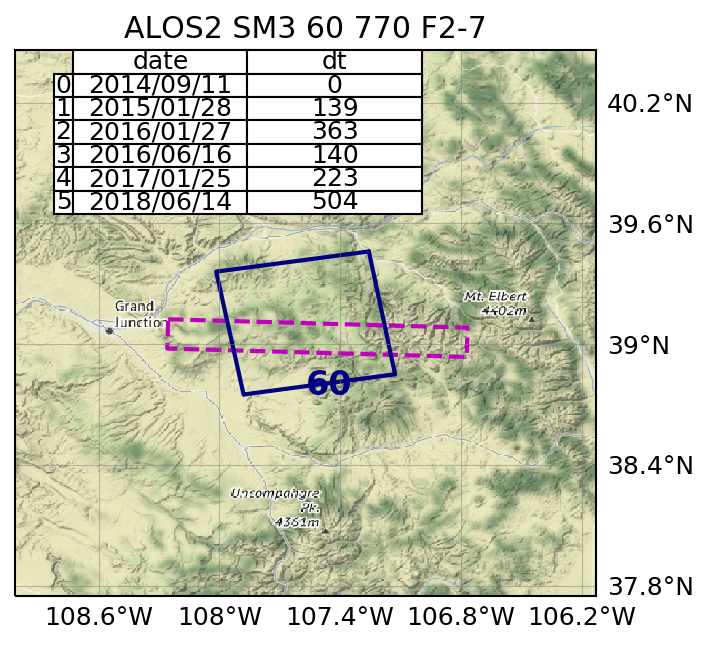

In [25]:
# Plot single frames on the map:
w, s, e, n = GF.geometry.cascaded_union.bounds
snwe = [s, n, w, e]
vectorFile = '/Users/scott/Documents/GitHub/snowex/snowex2019/co-nm/Name_GM2ER1_092aa.shp'
tmp = print_dates(GF)
plot_map(GF, snwe, vectorFile, title=f'ALOS2 {mode} {relativeOrbit} {frame} {beamNo}', tableFrame=tmp)
tmp

In [26]:
# Generate plots for all possible interferometric pairs (with dinosar naming scheme)
order = ["flightDirection", "opMode", "relativeOrbit", "frame", "beamNo"]
GF = gf.groupby(order).filter(lambda x: len(x["sceneId"]) > 2)
# Reprint summary as groupby object
GF.groupby(order)["sceneId"].count()

flightDirection  opMode  relativeOrbit  frame  beamNo
Ascending        SM3     59             770    F2-5      9
                                               F2-6      8
                                        780    F2-5      9
                         60             760    F2-7      6
                                        770    F2-6      5
                                               F2-7      6
Descending       SM3     160            2840   F2-7      5
Name: sceneId, dtype: int64

In [27]:
GB = GF.groupby(order)["sceneId"]
print(GB.groups)

{('Ascending', 'SM3', 59, 770, 'F2-5'): Int64Index([4, 12, 15, 21, 25, 38, 54, 63, 70], dtype='int64'), ('Ascending', 'SM3', 59, 770, 'F2-6'): Int64Index([6, 14, 17, 27, 48, 58, 65, 72], dtype='int64'), ('Ascending', 'SM3', 59, 780, 'F2-5'): Int64Index([5, 13, 16, 22, 26, 39, 55, 64, 71], dtype='int64'), ('Ascending', 'SM3', 60, 760, 'F2-7'): Int64Index([2, 10, 19, 23, 36, 67], dtype='int64'), ('Ascending', 'SM3', 60, 770, 'F2-6'): Int64Index([7, 18, 28, 60, 66], dtype='int64'), ('Ascending', 'SM3', 60, 770, 'F2-7'): Int64Index([3, 11, 20, 24, 37, 68], dtype='int64'), ('Descending', 'SM3', 160, 2840, 'F2-7'): Int64Index([50, 61, 62, 69, 73], dtype='int64')}


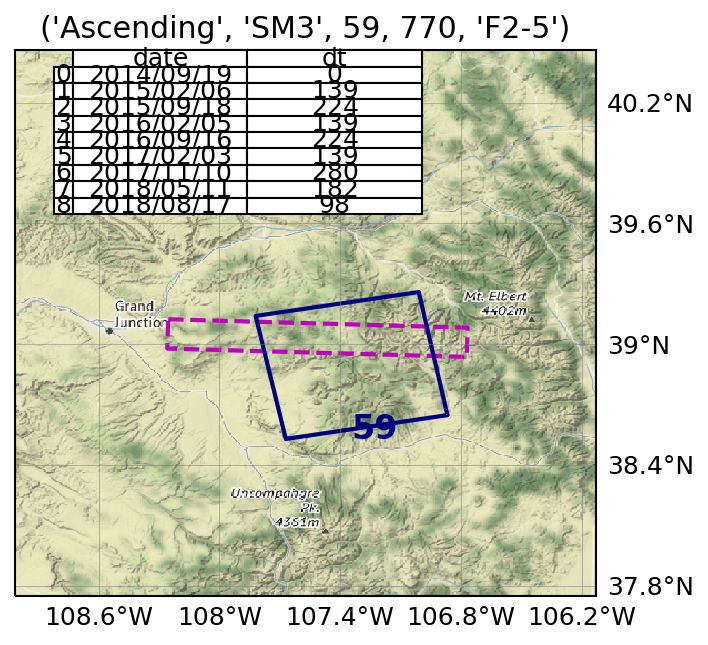

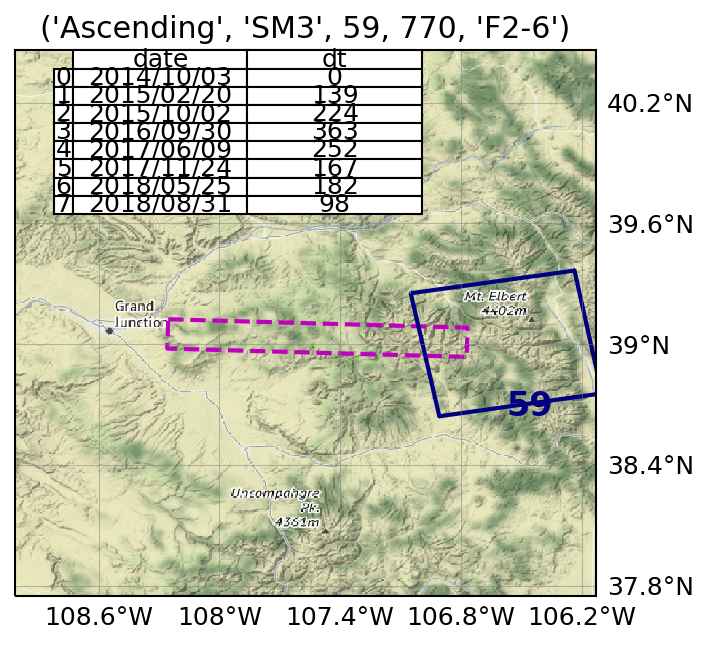

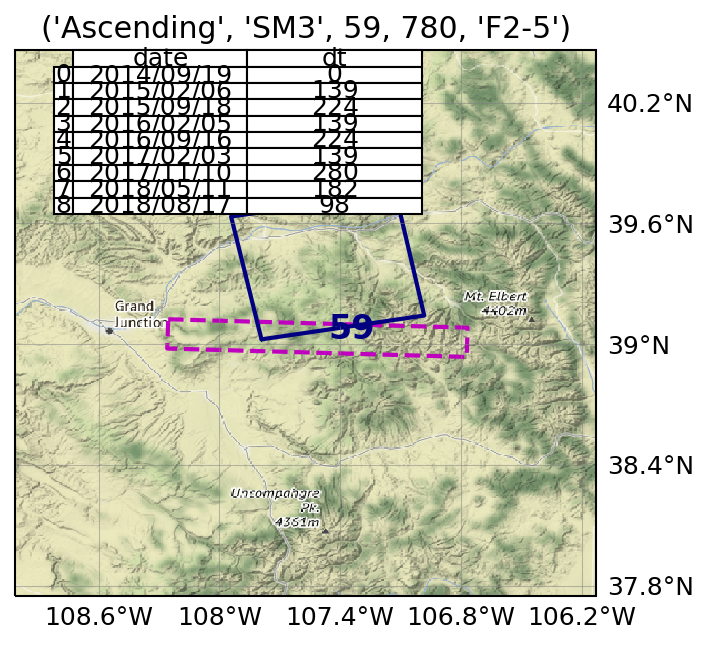

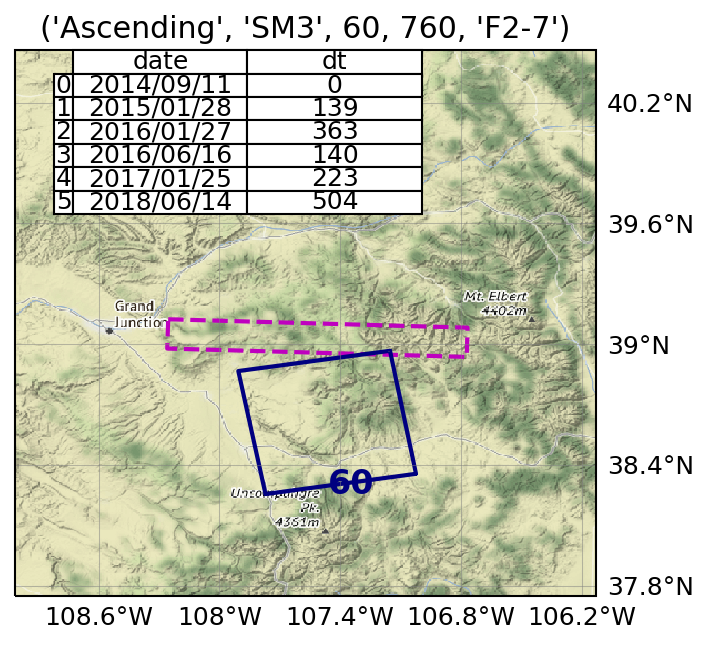

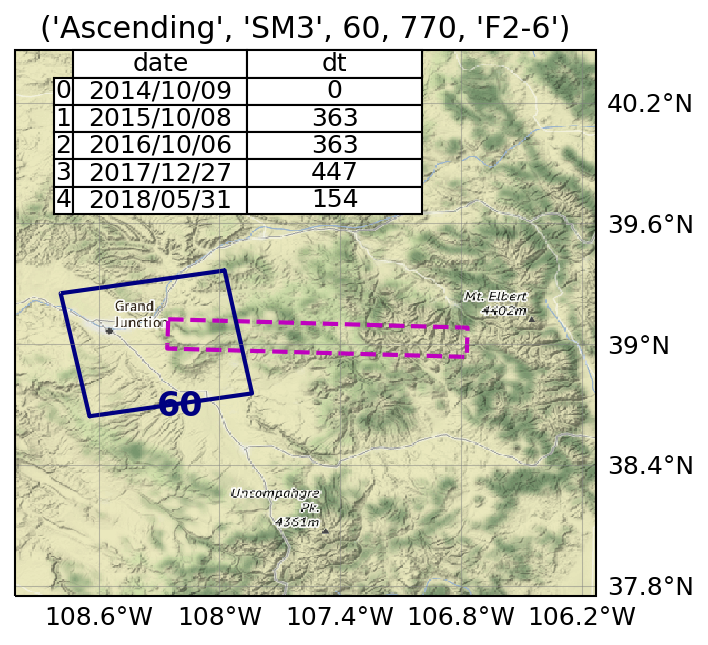

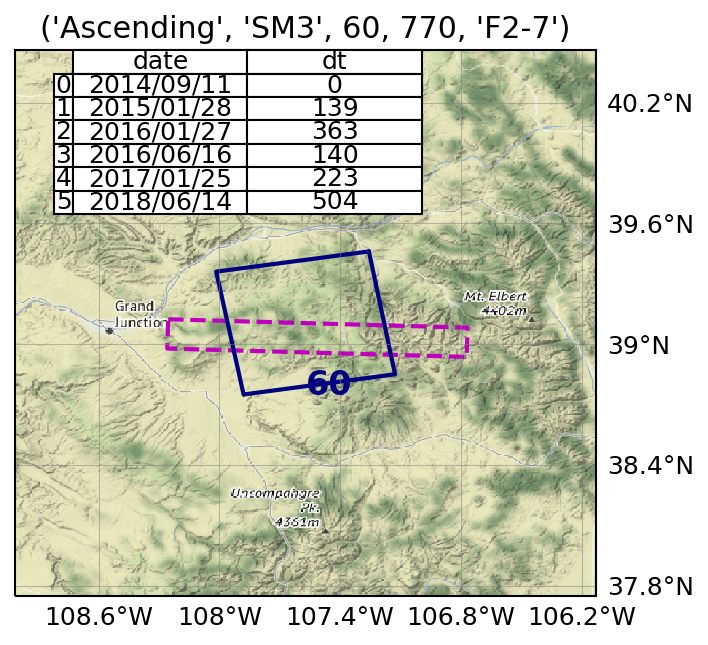

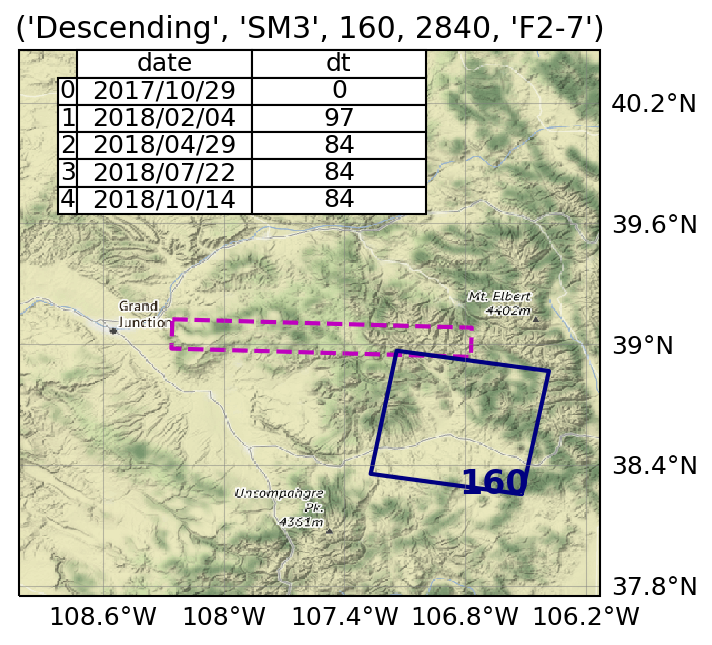

In [28]:
# Print maps for all combinations of possible interferometric pairs!
for labels, indices in GB.groups.items():
    #print(labels, indices)
    #print(labels, DF.loc[indices, "Scene ID"].tolist())
    inventory = GF.loc[indices]
    tmp = print_dates(inventory)
    plot_map(inventory, snwe, vectorFile, title=str(labels), tableFrame=tmp)